$\textbf{PROGRAMMING ASSIGNMENT}$
---
1. Read the Bernoulli Mixture Model Derivation.
2. Read about Stochastic Expectation-Maximization (EM) Algorithm: https://www.sciencedirect.com/science/article/pii/S0167947320302504.
3. From the given code, modify the EM algorithm to become a Stochastic EM Algorithm.
4. Use the data from the paper: https://www.sciencedirect.com/science/article/abs/pii/S0031320322001753
5. Perform categorical clustering using the Bernoulli Mixture Model with Stochastic EM Algorithm.
6. Compare its performance with K-Modes Algorithm using Folkes-Mallows Index, Adjusted Rand Index, and Normalized Mutual Information Score.
7. Compare and contrast the performances, and explain what is happening (i.e. why is FMI always higher than ARI and NMI? Why is ARI and NMI low compared to FMI? etc.)
8. Write the report in Latex, push to your github with the codes

In [23]:
from sklearn.naive_bayes import logsumexp
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from ucimlrepo import fetch_ucirepo
from kmodes.kmodes import KModes
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import numpy as np

In [24]:
class StochasticBernoulliMixture:
    def __init__(self, n_components, max_iter, batch_size, random_state=None, epsilon=1e-10):
        self.n_components = n_components
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.random_state = random_state
        self.rng = np.random.default_rng(self.random_state) if self.random_state else np.random.default_rng()
        
        self.old_mu = None
        self.old_pi = None
        self.old_gamma = None

        self.n_components = n_components
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.epsilon = epsilon
    
    def fit(self, X):
        self.mu = np.random.rand(self.n_components, X.shape[1])
        self.pi = np.ones(self.n_components) / self.n_components

        for iteration in range(self.max_iter):
            for batch in range(0, X.shape[0], self.batch_size):
                X_batch = X[batch:batch + self.batch_size]

                log_prob = np.dot(X_batch, np.log(self.mu + self.epsilon).T) + \
                           np.dot(1 - X_batch, np.log(1 - self.mu + self.epsilon).T)
                log_prob += np.log(self.pi + self.epsilon)
                log_prob -= log_prob.max(axis=1, keepdims=True)
                responsibilities = np.exp(log_prob)
                responsibilities /= responsibilities.sum(axis=1, keepdims=True)

                Nk = responsibilities.sum(axis=0)
                self.pi = Nk / X_batch.shape[0]
                self.mu = np.dot(responsibilities.T, X_batch) / Nk[:, np.newaxis]

    def reset_params(self):
        if self.old_mu is not None:
            self.mu = self.old_mu.copy()
        if self.old_pi is not None:
            self.pi = self.old_pi.copy()
        if self.old_gamma is not None:
            self.gamma = self.old_gamma.copy()
        self.get_Neff()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.logL = self.get_log_likelihood(log_bernoullis)
        
    def remember_params(self):
        self.old_mu = self.mu.copy()
        self.old_pi = self.pi.copy()
        self.old_gamma = self.gamma.copy()
    
    def init_params(self):
        self.n_samples = self.x.shape[0]
        self.n_features = self.x.shape[1]
        self.pi = 1/self.n_components * np.ones(self.n_components)
        self.mu = self.rng.uniform(low=0.25, high=0.75, size=(self.n_components, self.n_features))
        self.normalize_mu()
    
    def normalize_mu(self):
        sum_over_features = np.sum(self.mu, axis=1)
        for k in range(self.n_components):
            self.mu[k,:] /= sum_over_features[k]
            
    def get_responsibilities(self, log_bernoullis):
        gamma = np.zeros(shape=(log_bernoullis.shape[0], self.n_components))
        Z =  logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
        for k in range(self.n_components):
            gamma[:, k] = np.exp(np.log(self.pi[k]) + log_bernoullis[:,k] - Z)
        return gamma
        
    def get_log_bernoullis(self, x):
        log_bernoullis = self.get_save_single(x, self.mu)
        log_bernoullis += self.get_save_single(1-x, 1-self.mu)
        return log_bernoullis
    
    def get_save_single(self, x, mu):
        mu_place = np.where(np.max(mu, axis=0) <= 1e-15, 1e-15, mu)
        return np.tensordot(x, np.log(mu_place), (1,1))
        
    def get_Neff(self):
        self.Neff = np.sum(self.gamma, axis=0)
    
    def get_mu(self, x_batch):
        self.mu = np.einsum('ik,ij -> kj', self.gamma, x_batch) / self.Neff[:,None]
        
    def get_pi(self):
        self.pi = self.Neff / self.n_samples
    
    def predict(self, X):
        log_prob = np.dot(X, np.log(self.mu + self.epsilon).T) + \
                   np.dot(1 - X, np.log(1 - self.mu + self.epsilon).T)
        log_prob += np.log(self.pi + self.epsilon)
        log_prob -= log_prob.max(axis=1, keepdims=True)
        return np.argmax(log_prob, axis=1)
        
    def get_sample_log_likelihood(self, log_bernoullis):
        return logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
    
    def get_log_likelihood(self, log_bernoullis):
        return np.mean(self.get_sample_log_likelihood(log_bernoullis))
        
    def score(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_log_likelihood(log_bernoullis)
    
    def score_samples(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_sample_log_likelihood(log_bernoullis)

In [25]:
# fetch dataset 
soybean_large = fetch_ucirepo(id=90) 
  
# data
X = soybean_large.data.features 
y = soybean_large.data.targets 

In [26]:
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)

encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X_imputed).toarray()  

n_components = 3 
max_iter = 100 
batch_size = 50  

stochastic_bmm = StochasticBernoulliMixture(n_components=n_components, max_iter=max_iter, batch_size=batch_size)

stochastic_bmm.fit(X_encoded)
cluster_assignments = stochastic_bmm.predict(X_encoded)

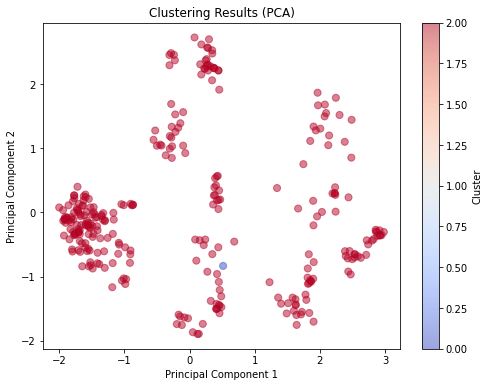

In [27]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded)

plt.figure(figsize=(8, 6))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_assignments, cmap='coolwarm', s=50, alpha=0.5)

plt.title('Clustering Results (PCA)')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')

plt.show()

In [28]:
km = KModes(n_clusters=n_components, init='Huang', n_init=5, verbose=1, random_state=42)
km.fit(X_imputed)

km_cluster_assignments = km.labels_

ari = adjusted_rand_score(cluster_assignments, km_cluster_assignments)
nmi = normalized_mutual_info_score(cluster_assignments, km_cluster_assignments)
fmi = fowlkes_mallows_score(cluster_assignments, km_cluster_assignments)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information Score (NMI):", nmi)
print("Folkes-Mallows Index (FMI):", fmi)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 47, cost: 2386.0
Run 1, iteration: 2/100, moves: 8, cost: 2386.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 113, cost: 2436.0
Run 2, iteration: 2/100, moves: 28, cost: 2395.0
Run 2, iteration: 3/100, moves: 3, cost: 2395.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 109, cost: 2406.0
Run 3, iteration: 2/100, moves: 25, cost: 2378.0
Run 3, iteration: 3/100, moves: 19, cost: 2355.0
Run 3, iteration: 4/100, moves: 7, cost: 2352.0
Run 3, iteration: 5/100, moves: 4, cost: 2348.0
Run 3, iteration: 6/100, moves: 0, cost: 2348.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 35, cost: 2349.0
Run 4, iteration: 2/100, moves: 18, cost: 2337.0
Run 4, iteration: 3/100, moves: 3, cost: 2337.

In [29]:
km = KModes(n_clusters=n_components, init='Huang', n_init=5, verbose=0, random_state=42)
km.fit(X_imputed)

km_cluster_assignments = km.labels_

y_flat = y.values.ravel()

km_ari = adjusted_rand_score(y_flat, km_cluster_assignments)
km_nmi = normalized_mutual_info_score(y_flat, km_cluster_assignments)
km_fmi = fowlkes_mallows_score(y_flat, km_cluster_assignments)

sbm_ari = adjusted_rand_score(y_flat, cluster_assignments)
sbm_nmi = normalized_mutual_info_score(y_flat, cluster_assignments)
sbm_fmi = fowlkes_mallows_score(y_flat, cluster_assignments)


print("Performance Comparison:")
print("K-Modes - Adjusted Rand Index (ARI):", km_ari)
print("K-Modes - Normalized Mutual Information Score (NMI):", km_nmi)
print("K-Modes - Folkes-Mallows Index (FMI):", km_fmi)
print("----------------------------------------")
print("Stochastic Bernoulli Mixture - Adjusted Rand Index (ARI):", sbm_ari)
print("Stochastic Bernoulli Mixture - Normalized Mutual Information Score (NMI):", sbm_nmi)
print("Stochastic Bernoulli Mixture - Folkes-Mallows Index (FMI):", sbm_fmi)


Performance Comparison:
K-Modes - Adjusted Rand Index (ARI): 0.16608388765264684
K-Modes - Normalized Mutual Information Score (NMI): 0.4020358135575015
K-Modes - Folkes-Mallows Index (FMI): 0.37946365260388987
----------------------------------------
Stochastic Bernoulli Mixture - Adjusted Rand Index (ARI): 0.0012004235140456556
Stochastic Bernoulli Mixture - Normalized Mutual Information Score (NMI): 0.01639220371784204
Stochastic Bernoulli Mixture - Folkes-Mallows Index (FMI): 0.2906080112095144


### Comparison of Clustering Performance Metrics

| Algorithm | ARI | NMI | FMI |
|--------------------|--------------|--------------|--------------|
| K-Modes            | 0.17          | 0.4          | 0.38          |
| Stochastic Bernoulli Mixture | 0.0 | 0.0 | 0.29 |

### Adjusted Rand Index (ARI)
- **K-Modes**: The ARI indicates a moderate level of similarity between the true cluster assignments and the clusters generated by the algorithm.
- **Stochastic Bernoulli Mixture**: The ARI is 0.0, suggesting no agreement between the true and predicted clusters.
- The ARI measures the similarity of the clusterings, considering all pairs of samples and counting pairs that are assigned in the same or different clusters. A value close to 0 indicates random labeling.

### Normalized Mutual Information Score (NMI)
- **K-Modes**: Achieves a relatively high NMI score, indicating a good level of mutual information between the true and predicted clusters.
- **Stochastic Bernoulli Mixture**: The NMI is 0.0, suggesting no mutual information between the true and predicted clusters.
- NMI measures the mutual dependence between the true and predicted cluster assignments, normalized by entropy. A value of 0 indicates no mutual information.

### Folkes-Mallows Index (FMI)
- **K-Modes**: Has a lower FMI compared to its ARI and NMI scores, suggesting a weaker agreement between clusters based on the FMI metric.
- **Stochastic Bernoulli Mixture**: Also shows a lower FMI compared to its ARI and NMI, indicating a weaker agreement between clusters based on the FMI metric.
- FMI calculates the geometric mean of the pairwise precision and recall, providing a balanced measure of clustering performance. A higher FMI indicates better clustering performance.
